# Music Genre Classification

This script trains a machine learning model to classify music genres based on song lyrics. The model is trained using a dataset containing songs with corresponding lyrics and genres. The genres are represented as lists of strings.

## Input Requirements
- The input dataset should be provided as a CSV file with the following columns:
    - `song`: String, representing the song name.
    - `artist`: String, representing the artist name.
    - `genres`: List of strings, representing the music genres associated with the song.
    - `lyrics`: String, representing the lyrics of the song.

## Dependencies
- Pandas
- NumPy
- TensorFlow (Keras)
- Scikit-learn
- Seaborn
- Matplotlib
- JSON

## Configuration
The configuration file 'config.json' includes settings such as the word embeddings file, word embedding dimensions, input length, and genre mappings.

## Execution
1. Load the dataset using the `load_datachunks` function.
2. Visualize the distribution of genres using the `visualize_data` function.
3. Split the dataset into training (70%), testing (15%), and validation (15%) sets.
4. Convert dataframes into inputs for processing.
5. Train models, including LSTM and CNN, and evaluate their performance.
6. Save the best-performing model to a file ('models/model_<model_name>.keras').

Note: Ensure the dataset follows the specified format for successful execution.

In [1]:
import pandas as pd
import ast
import numpy as np

from utils.data_prep import dataset_to_X_y, load_datachunks
from utils.data_visualization import visualize_data, plot_multilabel_confusion_matrix

from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, GlobalMaxPooling1D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

import json

In [2]:
json_file_path = 'config.json'
with open(json_file_path, 'r') as json_file:
    config_dict = json.load(json_file)

In [3]:
# Extracting global constants from the configuration
ALL_GENRES = config_dict['ALL_GENRES']  # All possible genres
GENRE_TO_INDEX = config_dict['GENRE_TO_INDEX']  # Mapping of genres to indices
INDEX_TO_GENRE = {index: genre for genre, index in GENRE_TO_INDEX.items()}  # Reverse mapping of indices to genres
WORD_EMBED_FILE = config_dict['WORD_EMBED_FILE']  # File containing word embeddings
DIMENSION_LENGTH = config_dict['WORD_EMBED_LEN']  # Dimension length of word embeddings
WORDS_PER_LINE = config_dict['INPUT_LENGTH']  # Number of words in each line of the lyrics

## Create Word Embeddings

In [4]:
def get_word_emb_dict():
    """
    Retrieves a dictionary of word embeddings from a specified file.

    Returns:
        dict: A dictionary where each word is a key, and the corresponding value is a NumPy array
              representing its word embedding.

    Note:
        The file format is assumed to have each line structured as 'word value1 value2 ... valueN'.
        The function skips lines that do not adhere to this format.
    """
    embedding = dict()
    with open(WORD_EMBED_FILE, 'r', encoding="utf8") as f:
        for line in f.readlines():
            line = line.split(' ')       
            try:
                embedding[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue 
    return embedding
# get our word embeddings dictionary to convert words to embeddings
word_embeddings = get_word_emb_dict()


## Create Models

In [5]:
def get_lstm():
    model = Sequential([
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu', 
          kernel_regularizer=regularizers.l2(0.01), 
          activity_regularizer=regularizers.l1(0.01)),
    Dense(len(ALL_GENRES.keys()), activation='sigmoid') 
    ])
    return model

def get_cnn():
    
    FILTERS = 250 # number of filters in your Convnet
    KERNEL_SIZE = 3 # a window size of 3 tokens (how many tokens to read at a time)

    
    cnn_model = Sequential()
    cnn_model.add(Conv1D(FILTERS, KERNEL_SIZE, padding = 'valid' , activation = 'relu',strides = 1 , input_shape = (WORDS_PER_LINE, DIMENSION_LENGTH)))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(250))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dense(len(ALL_GENRES.keys())))
    cnn_model.add(Activation('sigmoid'))
    
    return cnn_model

## Model Training + Evaluation

In [6]:
def train_model(model, train_data, val_data, epochs=10):
    
    x_train, y_train = train_data
    x_val, y_val = val_data
    
    # define optimizer and compile
    optimzer = Adam(learning_rate=.001)
    model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])

    # Create early stopping object
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

    # train the model
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping])
    
    return model, history

def eval_model(model, test_data):
    
    # get data we can train with 
    x_test, y_test = test_data

    # Evaluate model on test data
    score = model.evaluate(x_test, y_test, verbose=1)

    # Calculate precision, recall, F1 score
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5).astype(int) # round all elements above .5 up to 1 
    
    acc = accuracy_score(y_test, y_pred)
    #print('Precision:', precision_score(y_test_argmax, y_pred, average='weighted'))
    #print('Recall:', recall_score(y_test_argmax, y_pred, average='weighted'))
    #print('F1 score:', f1_score(y_test_argmax, y_pred, average='weighted'))
    #print('Accuracy:', acc)
    
    plot_multilabel_confusion_matrix(y_test, y_pred, INDEX_TO_GENRE)
    
    return acc 

In [7]:
def train_and_evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    
    Iterates through a dictionary of model names and corresponding functions to get models.
    Trains each model, evaluates its performance, and selects the best-performing model.
    
    Parameters:
    X_train, y_train (array-like): Training data.
    X_val, y_val (array-like): Validation data.
    
    Returns:
    the best model and its name.
    """
    
    best_score = 0
    best_model = None
    best_model_name = ''

    for model_name, get_model_func in models.items():
        print("Training:", model_name)
        model = get_model_func()
        model, hist = train_model(model, (X_train, y_train), (X_val, y_val))
        score = eval_model(model, (X_test, y_test))

        if score > best_score:
            best_score = score
            best_model = model
            best_model_name = model_name

    print("The best model is {} with an accuracy of {}".format(best_model_name, best_score))
    return best_model, best_model_name, best_score

#### Load in Data

In [8]:
 # load in data 
df = load_datachunks(1) # you can use this to load in the datachunk csv's (you can specify how many chunks to load in)
# df = pd.read_csv('data/custom/top100_dataset.csv') # alternatively you can train using the custom dataset or your own dataset like this
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
df = df[df['genres'].apply(lambda x: bool(x))]

Loaded dataframe chunks Successfully


count        1042
unique          9
top       hip hop
freq          495
dtype: object


c:\Users\Mikea\Song_Genre_Prediction\utils\data_visualization.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=genres_series, order=genres_series.value_counts().index, palette=pal)


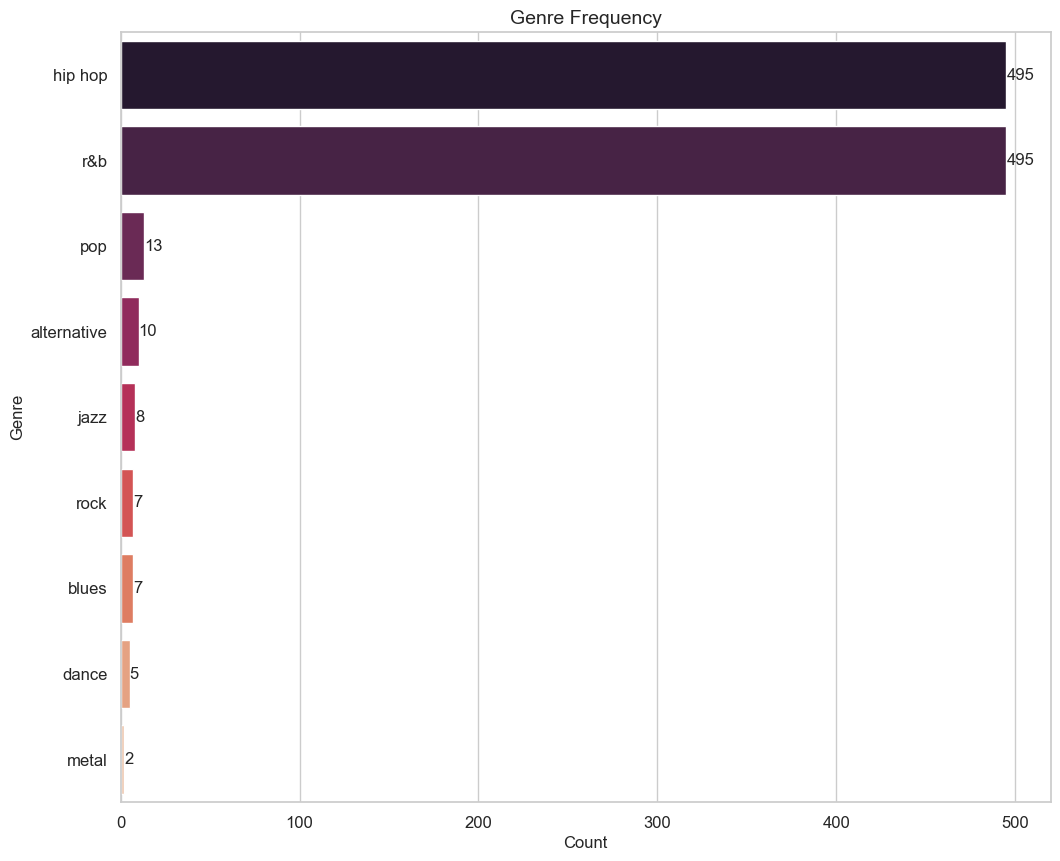

In [9]:
# visualize it so we can see 
visualize_data(df['genres'])

#### Preprocess data for training

In [10]:
# Split the DataFrame into training (70%), testing (15%), and validation (15%)
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# turn dataframes into inputs we can process 
X_train, y_train = dataset_to_X_y(train_df, word_embeddings)
X_test, y_test = dataset_to_X_y(test_df, word_embeddings)
X_val, y_val = dataset_to_X_y(val_df, word_embeddings)

#### Train and determine best model

Training: multi_class_lstm

Epoch 1/10


11/11 [==============================] - 37s 2s/step - loss: 1.3517 - accuracy: 0.0058 - val_loss: 1.1564 - val_accuracy: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 22s 2s/step - loss: 1.0691 - accuracy: 0.0000e+00 - val_loss: 0.9905 - val_accuracy: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 24s 2s/step - loss: 0.9113 - accuracy: 0.0000e+00 - val_loss: 0.8519 - val_accuracy: 0.0000e+00
Epoch 4/10
11/11 [==============================] - 25s 2s/step - loss: 0.7836 - accuracy: 0.0000e+00 - val_loss: 0.7388 - val_accuracy: 0.0000e+00
Epoch 5/10
11/11 [==============================] - 26s 2s/step - loss: 0.6768 - accuracy: 0.0000e+00 - val_loss: 0.6452 - val_accuracy: 0.0000e+00
Epoch 6/10
11/11 [==============================] - 32s 3s/step - loss: 0.5905 - accuracy: 0.0000e+00 - val_loss: 0.5685 - val_accuracy: 0.0000e+00
Epoch 7/10
11/11 [==============================] - 22s 2s/step - loss: 0.5186 - accur

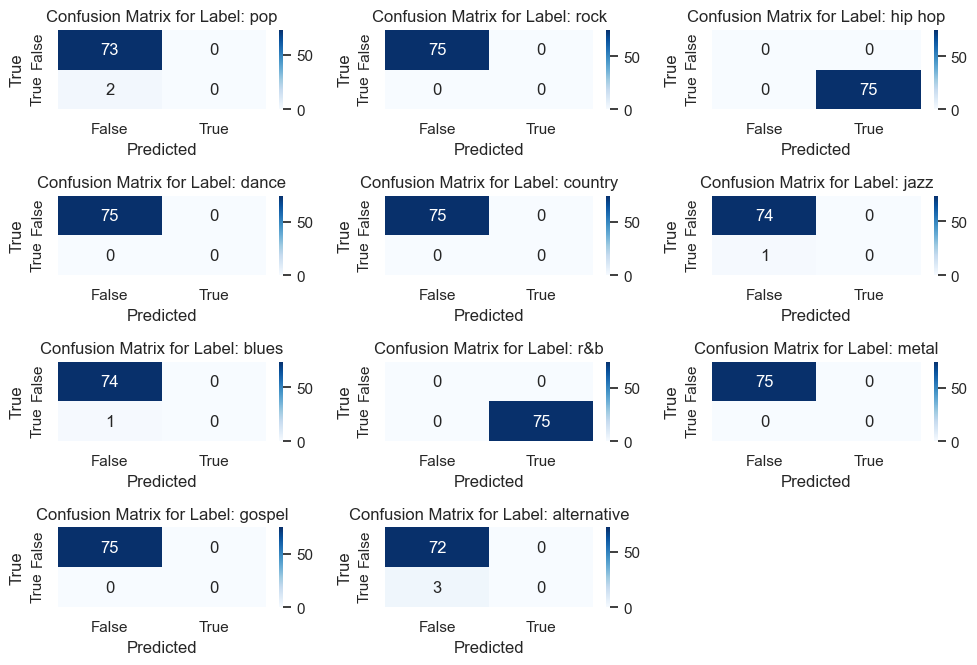

Training: multi_class_cnn
Epoch 1/10
11/11 [==============================] - 4s 162ms/step - loss: 0.1887 - accuracy: 0.4755 - val_loss: 0.1091 - val_accuracy: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 1s 105ms/step - loss: 0.0568 - accuracy: 0.3804 - val_loss: 0.1326 - val_accuracy: 0.2267
Epoch 3/10
11/11 [==============================] - 1s 103ms/step - loss: 0.0601 - accuracy: 0.5187 - val_loss: 0.1216 - val_accuracy: 0.9333
Epoch 4/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0508 - accuracy: 0.6225 - val_loss: 0.1049 - val_accuracy: 0.9467
Epoch 5/10
11/11 [==============================] - 1s 106ms/step - loss: 0.0469 - accuracy: 0.6657 - val_loss: 0.0998 - val_accuracy: 0.9467
Epoch 6/10
11/11 [==============================] - 1s 108ms/step - loss: 0.0445 - accuracy: 0.7349 - val_loss: 0.1007 - val_accuracy: 0.9467
Epoch 7/10
11/11 [==============================] - 1s 97ms/step - loss: 0.0407 - accuracy: 0.8934 - val_loss: 0.1028 

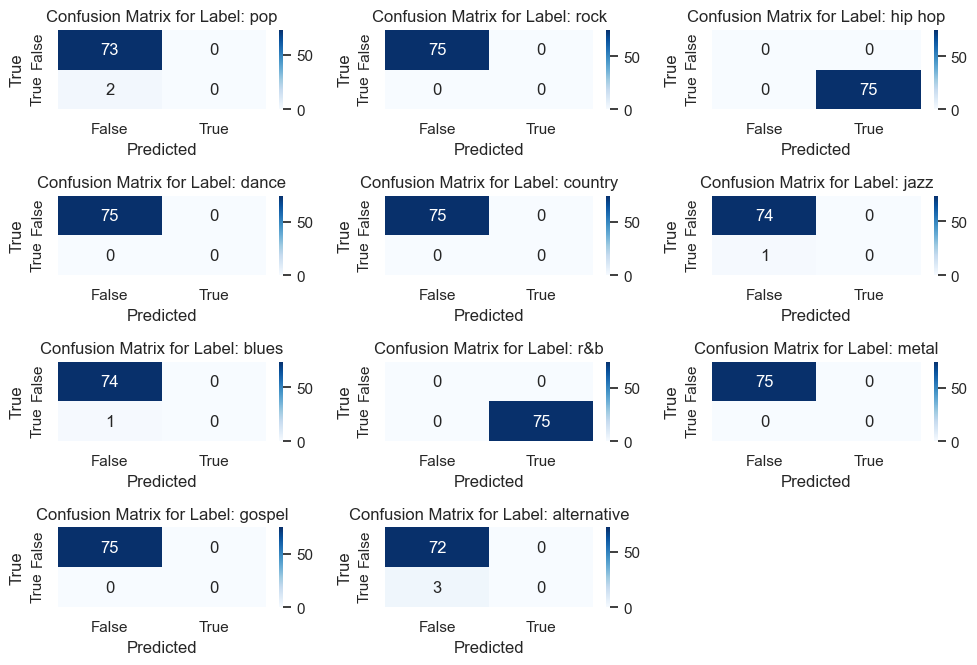

The best model is multi_class_lstm with an accuracy of 0.9333333333333333


In [11]:
# Define models
models = {
    'multi_class_lstm': get_lstm,
    'multi_class_cnn': get_cnn
}

# Train and evaluate models
best_model, best_model_name, best_score = train_and_evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test)

#### Save the best model

In [12]:
print("The best model is {} with a accuracy of {}".format(best_model_name, best_score)) 
best_model.save('models/model_{}.keras'.format(best_model_name))

The best model is multi_class_lstm with a accuracy of 0.9333333333333333
